In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(os.path.join(module_path, 'cnn-keras'))

In [2]:
%matplotlib inline

from keras.models import load_model
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import LearningRateScheduler, EarlyStopping, RemoteMonitor
from keras.utils import np_utils
import keras.backend as K
import numpy as np

import fs
import models
import utils

Using Theano backend.
Using gpu device 0: Quadro K620M (CNMeM is disabled, cuDNN 5004)


In [3]:
np.random.seed(47)

DATA_DIR = '../data/imdb-wiki-tiny-dataset'

TRAIN_DATA_OBJ = 'train_data'
VAL_DATA_OBJ = 'val_data'
TEST_DATA_OBJ = 'test_data'

class_names = ['female', 'male']
n_classes = 2

batch_size = 40
nb_epoch = 30
learning_rate = 1e-2
decay = 0.999
l2_reg = 1e-3

lr_boost_epoch = 20
lr_boost_value = 2e-2

X_train = np.load(fs.join(DATA_DIR, TRAIN_DATA_OBJ + '_00.npy')).astype(np.float32)
y_train = np.load(fs.join(DATA_DIR, TRAIN_DATA_OBJ + '_label_gender_00.npy')).astype(int)
Y_train = np_utils.to_categorical(y_train, n_classes)

X_val = np.load(fs.join(DATA_DIR, VAL_DATA_OBJ + '.npy')).astype(np.float32)
y_val = np.load(fs.join(DATA_DIR, VAL_DATA_OBJ + '_label_gender.npy')).astype(int)
Y_val = np_utils.to_categorical(y_val, n_classes)

X_test = np.load(fs.join(DATA_DIR, TEST_DATA_OBJ + '_00.npy')).astype(np.float32)
y_test = np.load(fs.join(DATA_DIR, TEST_DATA_OBJ + '_label_gender_00.npy')).astype(int)
Y_test = np_utils.to_categorical(y_test, n_classes)

class_weight = utils.get_class_weight(class_names, y_train)
print(class_weight)
    
def flip(X):
    return X.transpose((0,3,2,1))

def transform(X, mean=None, std=None):
    if std is not None:
        return flip((flip(X) - mean) / (std + 1e-8))
    elif mean is not None:
        return flip(flip(X) - mean)
    else:
        return X

ax = (0,1,2)
mean = flip(X_train).mean(ax)
std = flip(X_train).std(ax)

X_train = transform(X_train, mean, std)
X_val = transform(X_val, mean, std)
X_test = transform(X_test, mean, std)

model = models.get_simple_cnn(
    input_shape=(3,48,48), n_classes=n_classes,
    init='glorot_normal', # Seems to be more stable than glorot uniform (Xavier Initialization)
    batch_norm=True,      # Better generalization and faster convergence, no improvements with ELU (slower computation)
    l2_reg=l2_reg,        # Adds good generalization to the model
    activation='elu',     # Seems to converge much faster instead of ReLU
    dropout=0.5,          # More generalization, drop rand connections at training time,
    fc6=512, fc7=512
)

# Tried also Adam and RMSProp
# However only SGD seems to be stable and converges quickly
opt = SGD(lr=learning_rate, decay=decay)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

def scheduler(epoch):
    if epoch == lr_boost_epoch:
        model.optimizer.lr.set_value(lr_boost_value)
    return float(model.optimizer.lr.get_value())

cb_change_lr = LearningRateScheduler(scheduler)
cb_early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
cb_remote = RemoteMonitor(root='http://localhost:9000')

hist = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, class_weight=class_weight,
          verbose=1, validation_data=(X_val, Y_val), callbacks=[cb_change_lr, cb_early_stopping, cb_remote])

score = model.evaluate(X_test, Y_test, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

{0: 1.4962556165751373, 1: 1.0}
Train on 10000 samples, validate on 1000 samples
Epoch 1/30
10000/10000 [==============================] - 176s - loss: 3.6168 - acc: 0.5568 - val_loss: 0.9378 - val_acc: 0.5240
Epoch 2/30
10000/10000 [==============================] - 178s - loss: 3.4169 - acc: 0.5729 - val_loss: 0.7408 - val_acc: 0.6350
Epoch 3/30
10000/10000 [==============================] - 179s - loss: 3.3432 - acc: 0.5707 - val_loss: 0.7212 - val_acc: 0.6500
Epoch 4/30
10000/10000 [==============================] - 179s - loss: 3.3294 - acc: 0.5716 - val_loss: 0.7180 - val_acc: 0.6510
Epoch 5/30
10000/10000 [==============================] - 179s - loss: 3.2892 - acc: 0.5858 - val_loss: 0.7136 - val_acc: 0.6530
Epoch 6/30
10000/10000 [==============================] - 179s - loss: 3.3087 - acc: 0.5813 - val_loss: 0.7109 - val_acc: 0.6520
Epoch 7/30
10000/10000 [==============================] - 179s - loss: 3.2959 - acc: 0.5786 - val_loss: 0.7085 - val_acc: 0.6520
Epoch 8/30
10000

KeyboardInterrupt: 

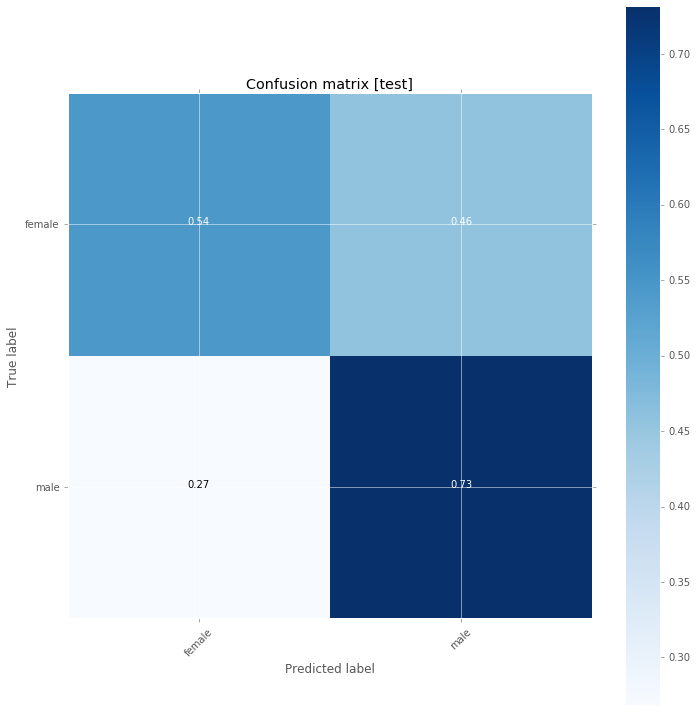

In [4]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = model.predict_classes(X_test, batch_size=batch_size, verbose=0)

cm = confusion_matrix(y_true, y_pred)

utils.plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Confusion matrix [test]')